# Dual Timeframe Environment (Experimental)
#### 23/05/03, AJ Zerouali

This notebook is a set of instructions for the use of the "dual timeframe" environment for portfolio optimization. The main feature is that the trading is allowed to be on a different schedule from the data collection

### Imports



In [1]:
# Kill warnings
from warnings import filterwarnings
filterwarnings("ignore")

# Usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# drl pfopt imports
from drl_pfopt import PFOpt_DRL_Agent
from drl_pfopt.common.benchmarks import get_eq_wts_benchmark

# Dual timeframe XP imports
from dual_timeframe_XP import (FeatureEngDualTF, 
                               PFOptDualTFEnv,
                               data_dict_split,
                               exec_random_weights,
                              )

from MyAlpaca import EX_1_LIST

### Data file

The dataset we load has a 15min data timeframe over extended trading hours.

In [2]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Reduce to 10 stocks
df_file = df_Alpaca_15min[df_Alpaca_15min.tic.isin(EX_1_LIST)].copy()
del df_Alpaca_15min

## A - Dual Timeframe Feature Engineer Class

### 1) Processing the data
Here is how one uses the new feature eng. class:

In [3]:
# Feature Engineer params
trade_timeframe = "Hour"
trade_ext_hours = True
N_lookback_trade_prds = 15
tech_ind_list = ["turbulence"]
use_return_covs = True

# Instantiate feature eng. object
processor = FeatureEngDualTF(tech_indicator_list = tech_ind_list,
                             use_return_covs = use_return_covs,
                             data_source = "Alpaca")


# Preprocess data
data_dict = processor.preprocess_data(df_X = df_file,
                                      trade_timeframe = trade_timeframe,
                                      trade_ext_hours = trade_ext_hours,
                                      N_lookback_trade_prds = N_lookback_trade_prds,)

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str), timeframe (str), and extended_trading_hours (bool)
Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [5]:
data_dict["trade_timeframe_info"]["day_list"]

[datetime.datetime(2022, 8, 2, 0, 0),
 datetime.datetime(2022, 8, 3, 0, 0),
 datetime.datetime(2022, 8, 4, 0, 0),
 datetime.datetime(2022, 8, 5, 0, 0),
 datetime.datetime(2022, 8, 8, 0, 0),
 datetime.datetime(2022, 8, 9, 0, 0),
 datetime.datetime(2022, 8, 10, 0, 0),
 datetime.datetime(2022, 8, 11, 0, 0),
 datetime.datetime(2022, 8, 12, 0, 0),
 datetime.datetime(2022, 8, 15, 0, 0),
 datetime.datetime(2022, 8, 16, 0, 0),
 datetime.datetime(2022, 8, 17, 0, 0),
 datetime.datetime(2022, 8, 18, 0, 0),
 datetime.datetime(2022, 8, 19, 0, 0),
 datetime.datetime(2022, 8, 22, 0, 0),
 datetime.datetime(2022, 8, 23, 0, 0),
 datetime.datetime(2022, 8, 24, 0, 0),
 datetime.datetime(2022, 8, 25, 0, 0),
 datetime.datetime(2022, 8, 26, 0, 0),
 datetime.datetime(2022, 8, 29, 0, 0),
 datetime.datetime(2022, 8, 30, 0, 0),
 datetime.datetime(2022, 8, 31, 0, 0),
 datetime.datetime(2022, 9, 1, 0, 0),
 datetime.datetime(2022, 9, 2, 0, 0),
 datetime.datetime(2022, 9, 6, 0, 0),
 datetime.datetime(2022, 9, 7, 0, 

The important changes in *FeatureEngDualTF* are the following:
1) The constructor takes only 3 parameters as shown below. 
2) The main method *preprocess_data()* now takes 4 parameters:
    * The df_X dataframe to process.
    * The required trading timeframe.
    * Whether the trading is over extended hours.
    * The *N_lookback_trade_prds* that replaces *N_lookback_prds*.
3) The output of *preprocess_data()* returns a dictionary *data_dict* with 5 keys:
    * "df": The processed dataframe to which the technical indicators were added, and from which the last daily timestamps (16:00 and 23:00) have been removed. We use the convention that a day ends when the next one starts.
    * "np_close_returns": np.array of close returns. If *use_returns_covs* is False, this array is empty. See also the remark on lookback periods.
    * "np_returns_covs": np.array of close return covariances. If *use_returns_covs* is False, this array is empty.  See also the remark on lookback periods.
    * "data_timeframe_info": The information dict required to reconstruct the list of data timestamps in df_X.
    * "trade_timeframe_info": A second timeframe info dict, with more keys than the data timeframe info. See the trade_timeframe_info remarks below.
    * "feature_shape_dict": A dictionary of feature shapes. The keys are the features in the data_dict (df and np_ arrays), the values are the no. of rows of each feature and the number of assets in the df. This dictionary is used by the dual timeframe environment to build the dataset array *env.X*. 
2) **About trade_timeframe_info**: This dictionary contains 4 keys that arent present in the *data_timeframe_info*, and that are **crucial** to the functioning of the environment:
    * *trade_timestamp_list*: The list of timestamps at which the portfolio is rebalanced. This list becomes the *env.date_hist* attribute of the environment.
    * "n_intradtrading_timestamps": The number of data timestamps in one trading period. Many computations rely on this number.
    * *N_lookback_trade_prds*: This integer replaces *N_lookback_prds* in this new version
    * *trading_data_schedule*: 

### 2) Data split helper function

For this version, the data split helper function needs to produce 2 data dictionaries. This is done with *data_dict_split()*, which takes only 2 parameters:
* The *data_dict* that we want to split, **which must be produced by the feature engineer.**
* The *split_date* string, the day in YYYY-MM-DD format at which we want to split the data.

In [4]:
# Data split
split_date = "2022-10-18"
data_dict_train, data_dict_test = data_dict_split(data_dict, split_date)

## B - Dual Timeframe Environment Class

### 1) Training and testing environments

In [7]:
# Env parameters
state_struct_list = ["volume", "close_returns", "returns_cov", "weights"]
weight_normalization = "relu"
transaction_cost_pct = 0.0
reward_type = "portfolio_return"
pf_value_ini = 100000.0
plot_prds_end_episode=40

# Training environment
env_train = PFOptDualTFEnv(data_dict = data_dict_train,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

# Testing environment
env_test = PFOptDualTFEnv(data_dict = data_dict_test,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

Here are the main changes:

### 2) Equal weights benchmarks

Initial portfolio value: 100000.0
End portfolio value: 92327.96870956614
Yearly Sharpe ratio at last period: -0.4758989339774107
Plotting portfolio values and weights for last 40 periods:


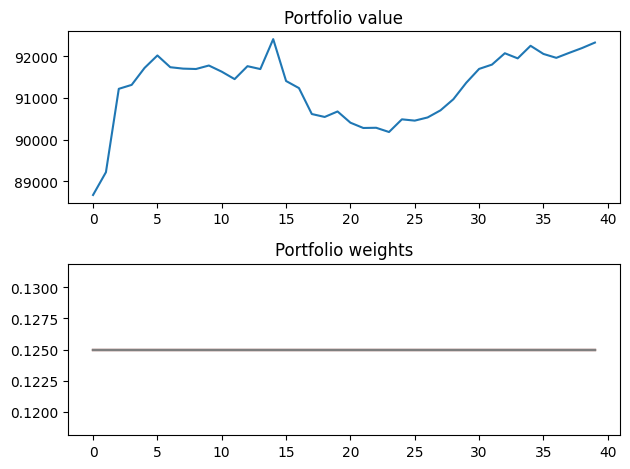

In [8]:
# Get equal weights benchmark for training period
ew_benchmark_dict_train = get_eq_wts_benchmark(env_train)

df_ew_train_value_hist = ew_benchmark_dict_train["value_hist"]
df_ew_train_return_hist = ew_benchmark_dict_train["return_hist"]
df_ew_train_returns = df_ew_train_return_hist.set_index(keys = "date", drop=True)
df_ew_train_perf_stats = ew_benchmark_dict_train["performance_stats"]

Initial portfolio value: 100000.0
End portfolio value: 105623.87681823185
Yearly Sharpe ratio at last period: 1.857103092895856
Plotting portfolio values and weights for last 40 periods:


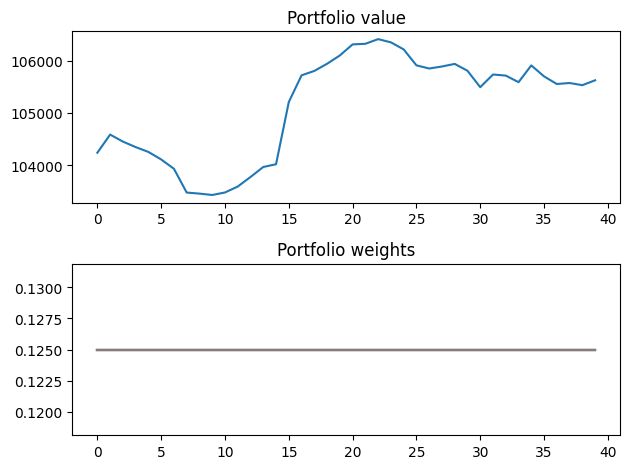

In [9]:
# Get equal weights benchmark for testing period
ew_benchmark_dict_test = get_eq_wts_benchmark(env_test)

df_ew_test_value_hist = ew_benchmark_dict_test["value_hist"]
df_ew_test_return_hist = ew_benchmark_dict_test["return_hist"]
df_ew_test_returns = df_ew_test_return_hist.set_index(keys = "date", drop=True)
df_ew_test_perf_stats = ew_benchmark_dict_test["performance_stats"]

#### C - TD3 Agent - Training


In [10]:
from drl_pfopt.sb3_extras.td3.td3_dropout_policy import TD3DropOutPolicy

In [ ]:
del TD3_Agent

In [11]:
TD3_Agent = PFOpt_DRL_Agent(train_env=env_train)

In [12]:
TD3_POLICY = TD3DropOutPolicy
TD3_POLICY_KWARGS = {"n_critics":1,
                     "add_input_dropout":True,}
TD3_MODEL_KWARGS = {"batch_size": 1, 
              "buffer_size": 10000,
              "learning_rate": 0.01,
              "gamma":0,
              "train_freq": (5, "step"),
              "policy_delay":1,
              "learning_starts":5,
              "action_noise":"ornstein_uhlenbeck",}


In [13]:
TD3_Agent.set_model(model_name = "td3",
                   policy = TD3_POLICY,
                   policy_kwargs=TD3_POLICY_KWARGS,
                   model_kwargs=TD3_MODEL_KWARGS,)

{'batch_size': 1, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'train_freq': (5, 'step'), 'policy_delay': 1, 'learning_starts': 5, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


True

Output()

=================================

Initial portfolio value: 100000.0

End portfolio value: 87832.75284192685

Yearly Sharpe ratio at last period: -0.5685515113097829

=================================

Plotting portfolio values and weights for last 40 periods:

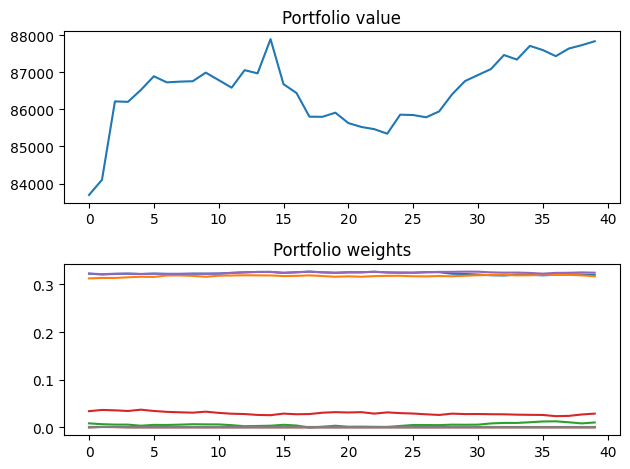

=================================

Initial portfolio value: 100000.0

End portfolio value: 87922.39701818497

Yearly Sharpe ratio at last period: -0.5756455810167751

=================================

Plotting portfolio values and weights for last 40 periods:

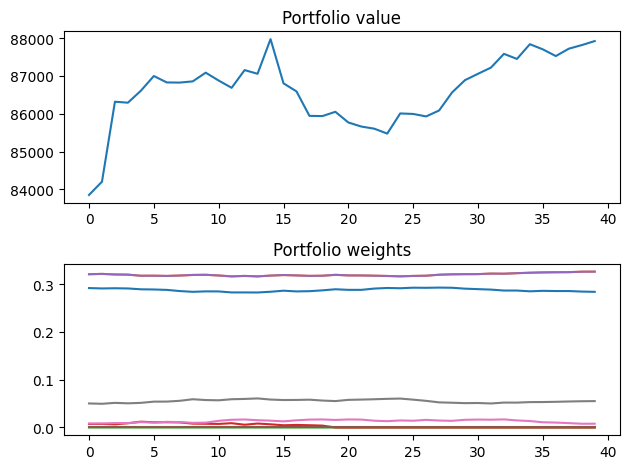

=================================

Initial portfolio value: 100000.0

End portfolio value: 90805.7933051026

Yearly Sharpe ratio at last period: -0.4916184926227529

=================================

Plotting portfolio values and weights for last 40 periods:

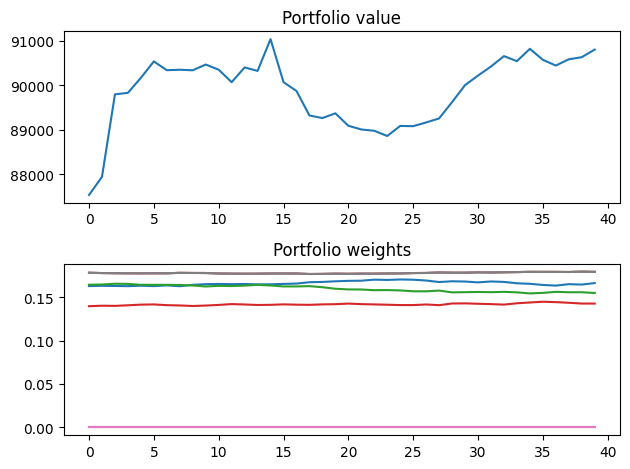

=================================

Initial portfolio value: 100000.0

End portfolio value: 93183.57380083503

Yearly Sharpe ratio at last period: -0.409013465536013

=================================

Plotting portfolio values and weights for last 40 periods:

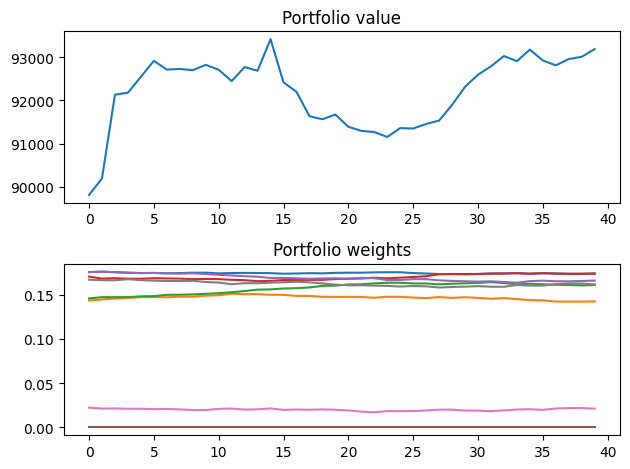

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 811      |
|    ep_rew_mean     | -0.1     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 123      |
|    time_elapsed    | 26       |
|    total_timesteps | 3244     |
| train/             |          |
|    actor_loss      | 0.145    |
|    critic_loss     | 0.452    |
|    learning_rate   | 0.01     |
|    n_updates       | 3235     |
---------------------------------


=================================

Initial portfolio value: 100000.0

End portfolio value: 93141.80537370576

Yearly Sharpe ratio at last period: -0.4103865182369254

=================================

Plotting portfolio values and weights for last 40 periods:

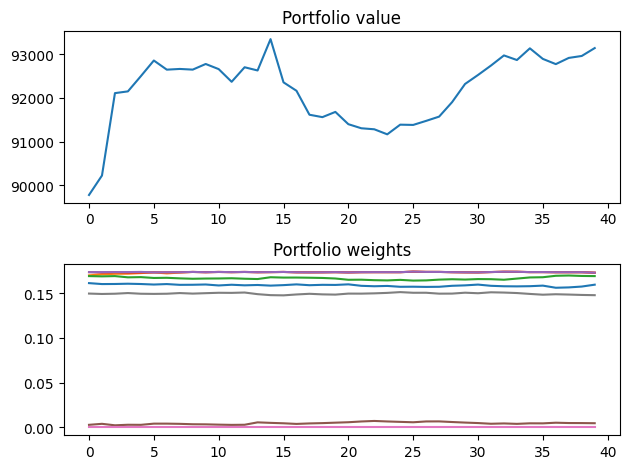

=================================

Initial portfolio value: 100000.0

End portfolio value: 93011.68518114423

Yearly Sharpe ratio at last period: -0.4115681125860949

=================================

Plotting portfolio values and weights for last 40 periods:

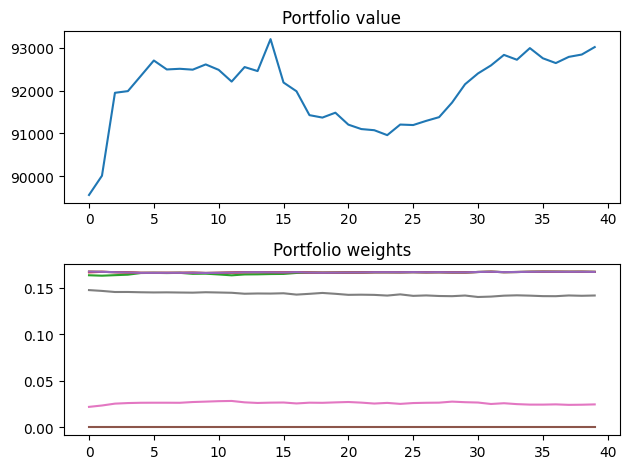

=================================

Initial portfolio value: 100000.0

End portfolio value: 93004.24372696294

Yearly Sharpe ratio at last period: -0.41860137546166554

=================================

Plotting portfolio values and weights for last 40 periods:

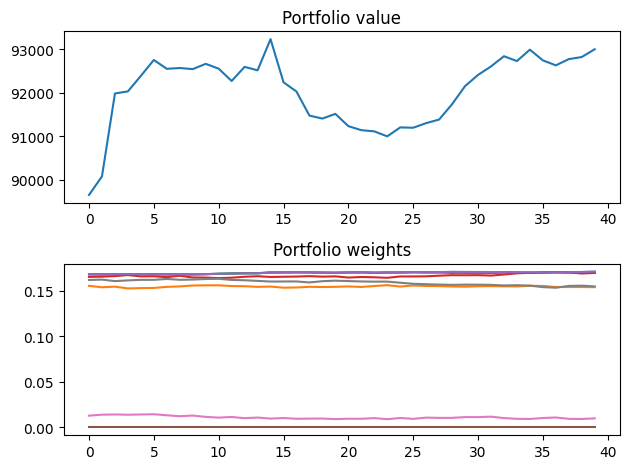

=================================

Initial portfolio value: 100000.0

End portfolio value: 93120.60180585244

Yearly Sharpe ratio at last period: -0.4057147355830753

=================================

Plotting portfolio values and weights for last 40 periods:

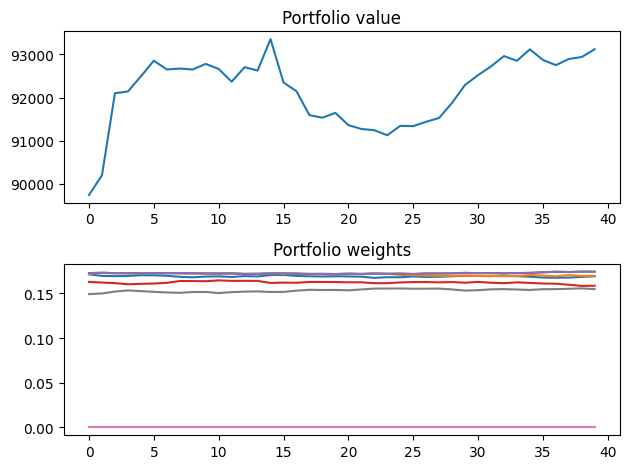

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 811      |
|    ep_rew_mean     | -0.084   |
| time/              |          |
|    episodes        | 8        |
|    fps             | 125      |
|    time_elapsed    | 51       |
|    total_timesteps | 6488     |
| train/             |          |
|    actor_loss      | -0.308   |
|    critic_loss     | 1.07     |
|    learning_rate   | 0.01     |
|    n_updates       | 6480     |
---------------------------------


=================================

Initial portfolio value: 100000.0

End portfolio value: 93314.41218633871

Yearly Sharpe ratio at last period: -0.3933754372551935

=================================

Plotting portfolio values and weights for last 40 periods:

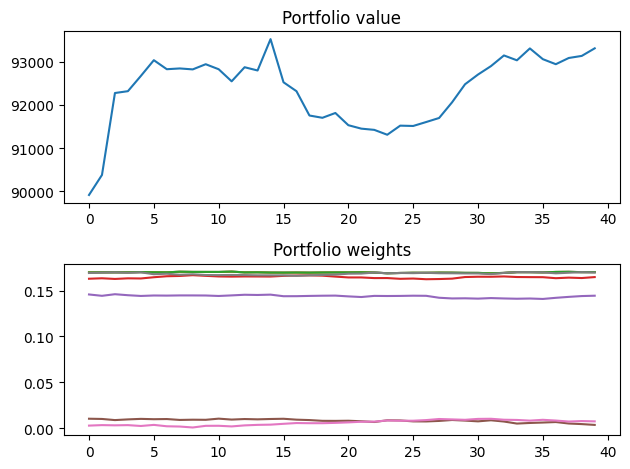

=================================

Initial portfolio value: 100000.0

End portfolio value: 93163.40410361328

Yearly Sharpe ratio at last period: -0.4113954781240155

=================================

Plotting portfolio values and weights for last 40 periods:

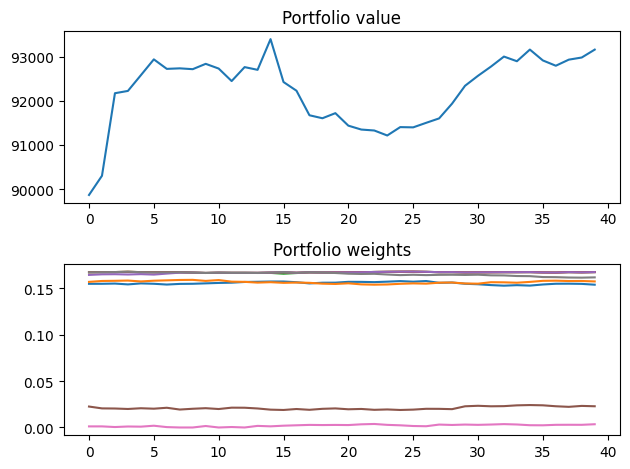

=================================

Initial portfolio value: 100000.0

End portfolio value: 93151.89276418577

Yearly Sharpe ratio at last period: -0.4047776400312658

=================================

Plotting portfolio values and weights for last 40 periods:

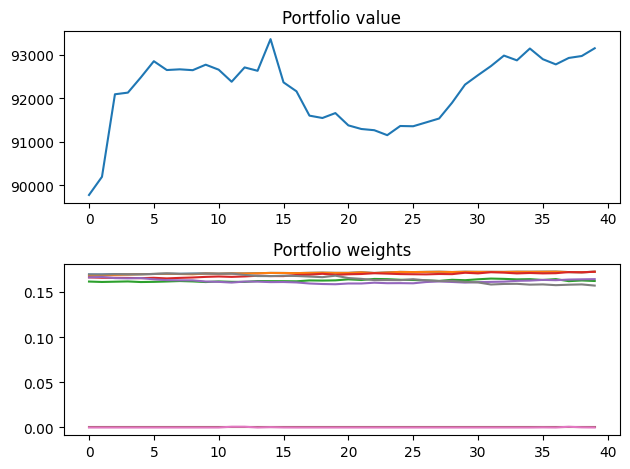

=================================

Initial portfolio value: 100000.0

End portfolio value: 93038.12233033456

Yearly Sharpe ratio at last period: -0.4165393705912082

=================================

Plotting portfolio values and weights for last 40 periods:

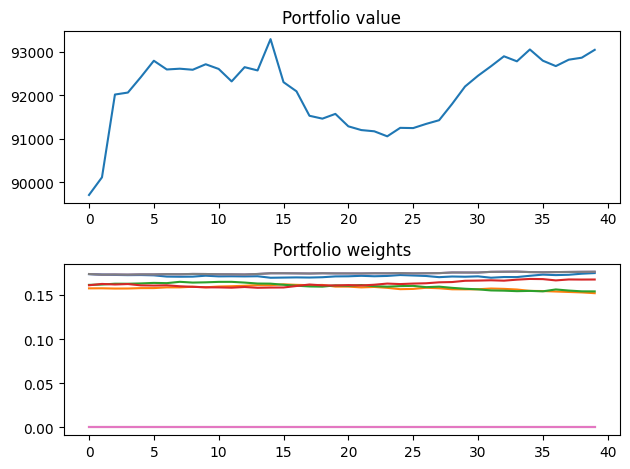

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 811      |
|    ep_rew_mean     | -0.0782  |
| time/              |          |
|    episodes        | 12       |
|    fps             | 126      |
|    time_elapsed    | 77       |
|    total_timesteps | 9732     |
| train/             |          |
|    actor_loss      | 0.375    |
|    critic_loss     | 1.12     |
|    learning_rate   | 0.01     |
|    n_updates       | 9725     |
---------------------------------


=================================

Initial portfolio value: 100000.0

End portfolio value: 92897.64764279511

Yearly Sharpe ratio at last period: -0.42661616187710993

=================================

Plotting portfolio values and weights for last 40 periods:

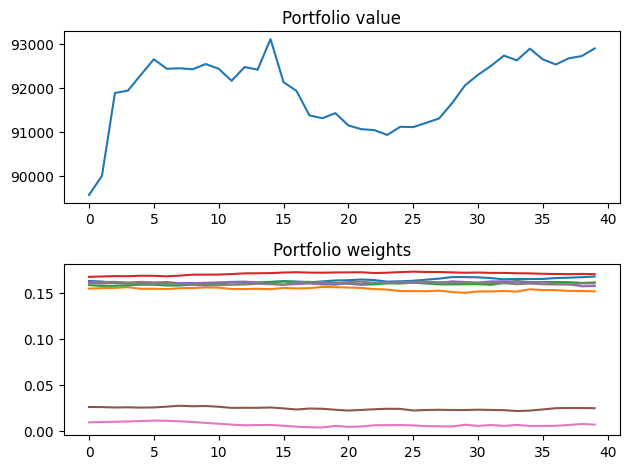

=================================

Initial portfolio value: 100000.0

End portfolio value: 93152.47188068833

Yearly Sharpe ratio at last period: -0.40832021087766635

=================================

Plotting portfolio values and weights for last 40 periods:

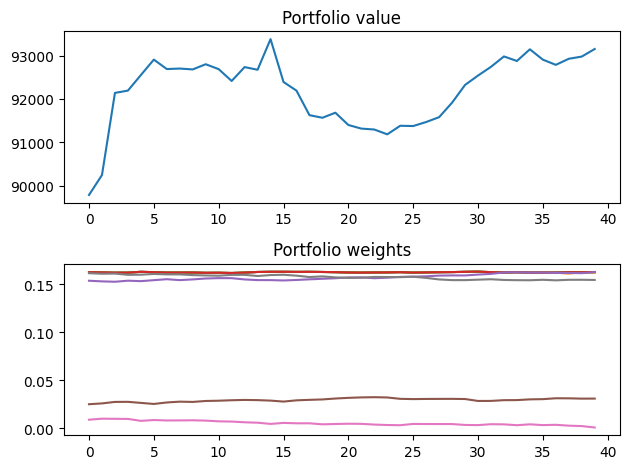

=================================

Initial portfolio value: 100000.0

End portfolio value: 93200.67019945291

Yearly Sharpe ratio at last period: -0.40529699899861393

=================================

Plotting portfolio values and weights for last 40 periods:

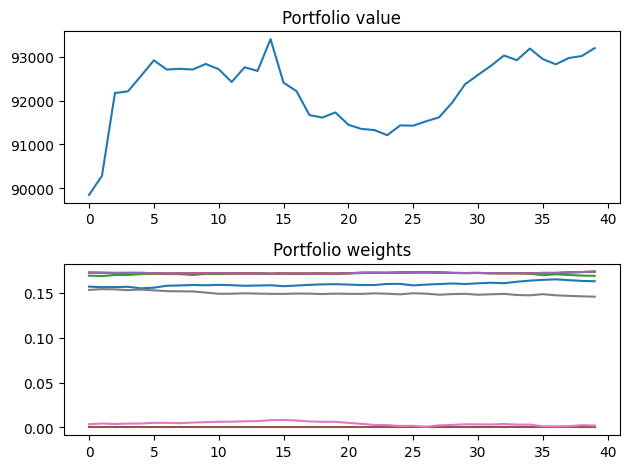

=================================

Initial portfolio value: 100000.0

End portfolio value: 93261.56207776496

Yearly Sharpe ratio at last period: -0.3983790415261546

=================================

Plotting portfolio values and weights for last 40 periods:

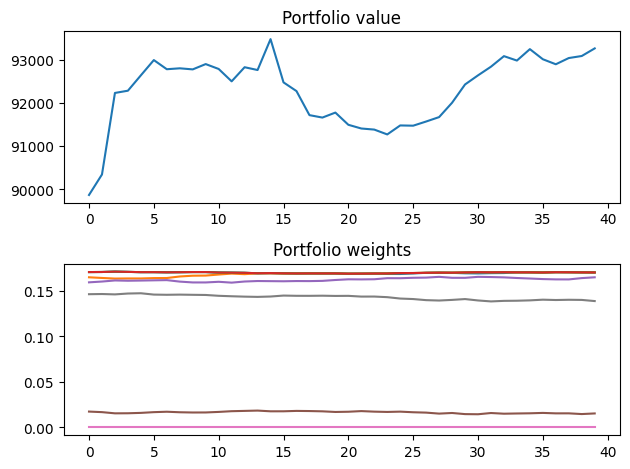

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 811      |
|    ep_rew_mean     | -0.0754  |
| time/              |          |
|    episodes        | 16       |
|    fps             | 126      |
|    time_elapsed    | 102      |
|    total_timesteps | 12976    |
| train/             |          |
|    actor_loss      | 0.486    |
|    critic_loss     | 0.98     |
|    learning_rate   | 0.01     |
|    n_updates       | 12970    |
---------------------------------


=================================

Initial portfolio value: 100000.0

End portfolio value: 93003.84855182799

Yearly Sharpe ratio at last period: -0.41900837896244086

=================================

Plotting portfolio values and weights for last 40 periods:

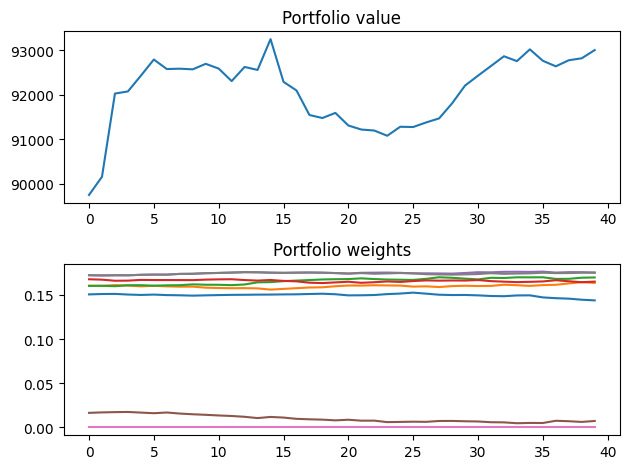

=================================

Initial portfolio value: 100000.0

End portfolio value: 93093.93156867876

Yearly Sharpe ratio at last period: -0.4130925073705862

=================================

Plotting portfolio values and weights for last 40 periods:

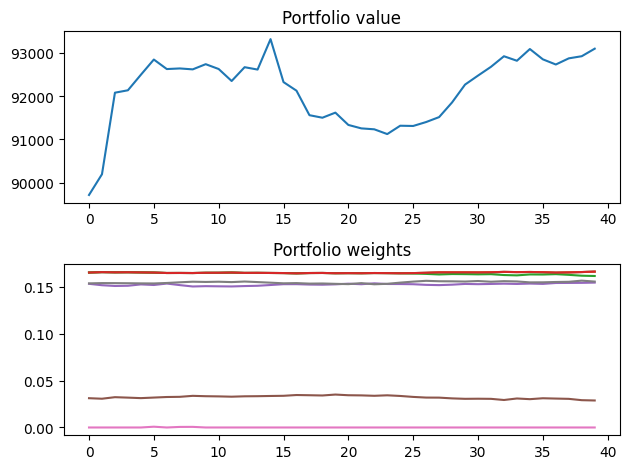

=================================

Initial portfolio value: 100000.0

End portfolio value: 93489.45242291607

Yearly Sharpe ratio at last period: -0.38735450592443005

=================================

Plotting portfolio values and weights for last 40 periods:

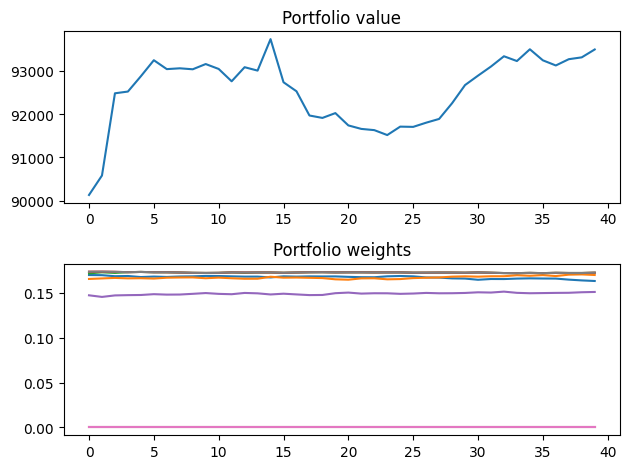

=================================

Initial portfolio value: 100000.0

End portfolio value: 92987.51179675692

Yearly Sharpe ratio at last period: -0.41800075106839807

=================================

Plotting portfolio values and weights for last 40 periods:

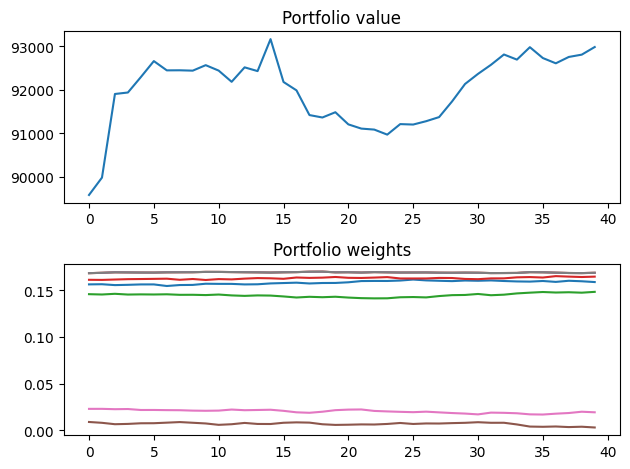

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 811      |
|    ep_rew_mean     | -0.0737  |
| time/              |          |
|    episodes        | 20       |
|    fps             | 127      |
|    time_elapsed    | 127      |
|    total_timesteps | 16220    |
| train/             |          |
|    actor_loss      | -0.246   |
|    critic_loss     | 1.25     |
|    learning_rate   | 0.01     |
|    n_updates       | 16210    |
---------------------------------


=================================

Initial portfolio value: 100000.0

End portfolio value: 93067.15996202124

Yearly Sharpe ratio at last period: -0.4100127331761579

=================================

Plotting portfolio values and weights for last 40 periods:

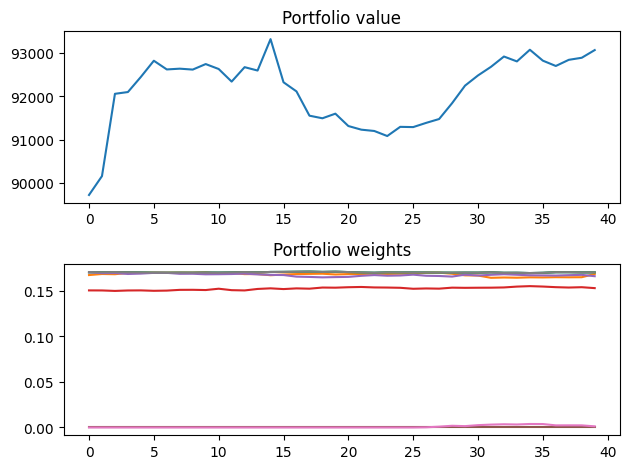

=================================

Initial portfolio value: 100000.0

End portfolio value: 92924.14533471833

Yearly Sharpe ratio at last period: -0.4252506778871485

=================================

Plotting portfolio values and weights for last 40 periods:

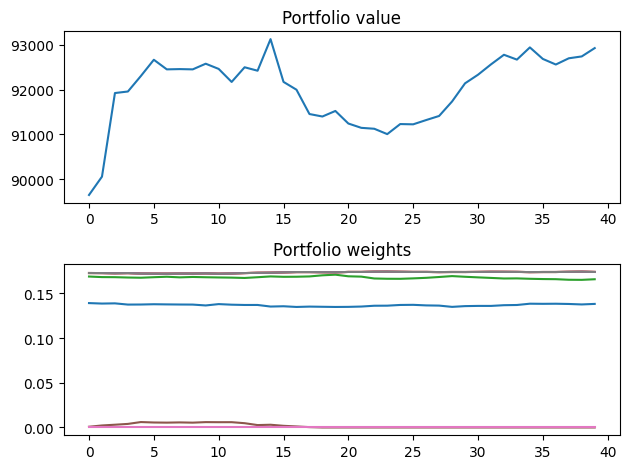

=================================

Initial portfolio value: 100000.0

End portfolio value: 93035.493144967

Yearly Sharpe ratio at last period: -0.4109411782204914

=================================

Plotting portfolio values and weights for last 40 periods:

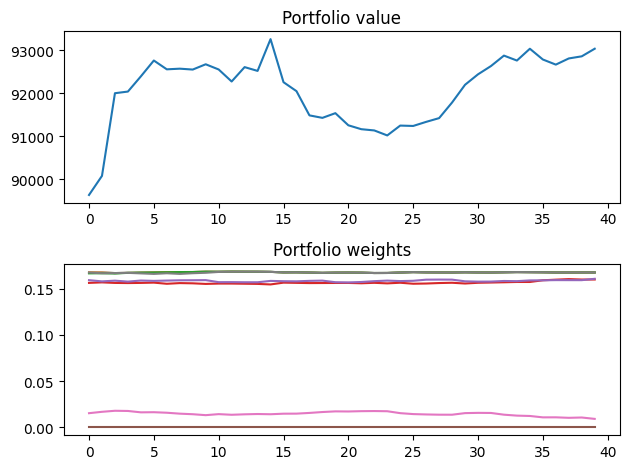

=================================

Initial portfolio value: 100000.0

End portfolio value: 93404.57025275938

Yearly Sharpe ratio at last period: -0.3941572645098283

=================================

Plotting portfolio values and weights for last 40 periods:

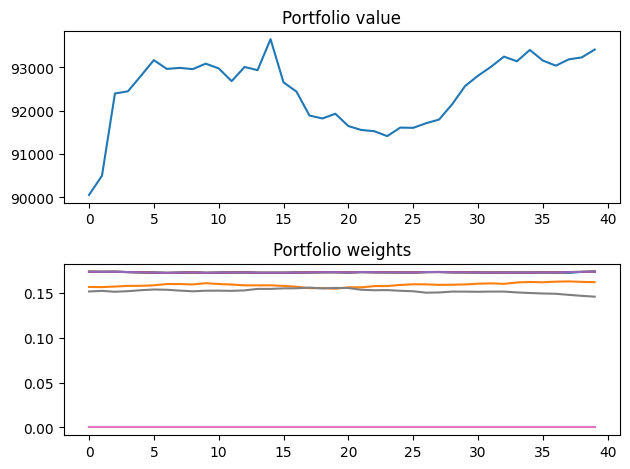

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 811      |
|    ep_rew_mean     | -0.0726  |
| time/              |          |
|    episodes        | 24       |
|    fps             | 127      |
|    time_elapsed    | 152      |
|    total_timesteps | 19464    |
| train/             |          |
|    actor_loss      | -0.294   |
|    critic_loss     | 0.24     |
|    learning_rate   | 0.01     |
|    n_updates       | 19455    |
---------------------------------


In [14]:
%matplotlib inline
TD3_Agent.train_model(tb_log_name='td3',
                     n_train_rounds=24,
                     progress_bar=True,
                    )

#### D - TD3 Agent Backtest


Initial portfolio value: 100000.0
End portfolio value: 106574.17647574398
Yearly Sharpe ratio at last period: 2.102568571931669
Plotting portfolio values and weights for last 40 periods:


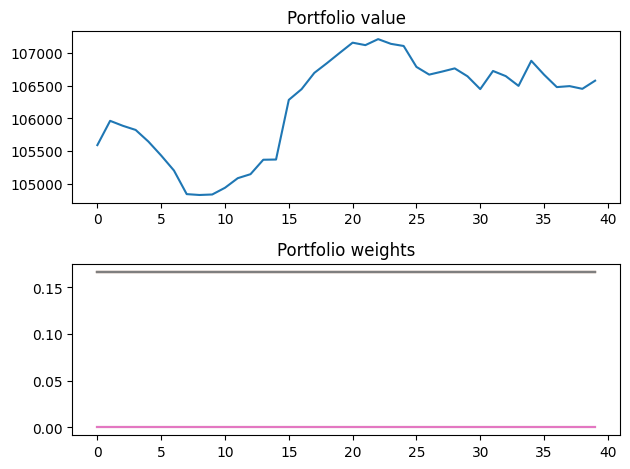

Finished running backtest. Storing results...


In [15]:
test_backtest_result_dict = TD3_Agent.run_backtest(test_env = env_test)

Start date,2022-10-18
End date,2022-11-01
Total months,7
,Backtest
Annual return,11.0%
Cumulative returns,6.4%
Annual volatility,5.1%
Sharpe ratio,2.06
Calmar ratio,4.80
Stability,0.89
Max drawdown,-2.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.29,2022-10-20,2022-10-21,2022-10-21,2
1,2.02,2022-10-26,2022-10-26,2022-10-28,3
2,0.92,2022-10-18,2022-10-18,2022-10-18,1
3,0.81,2022-10-18,2022-10-19,2022-10-19,1
4,0.71,2022-10-28,2022-10-31,NaT,NaN


Stress Events,mean,min,max
New Normal,0.04%,-0.78%,1.10%


True

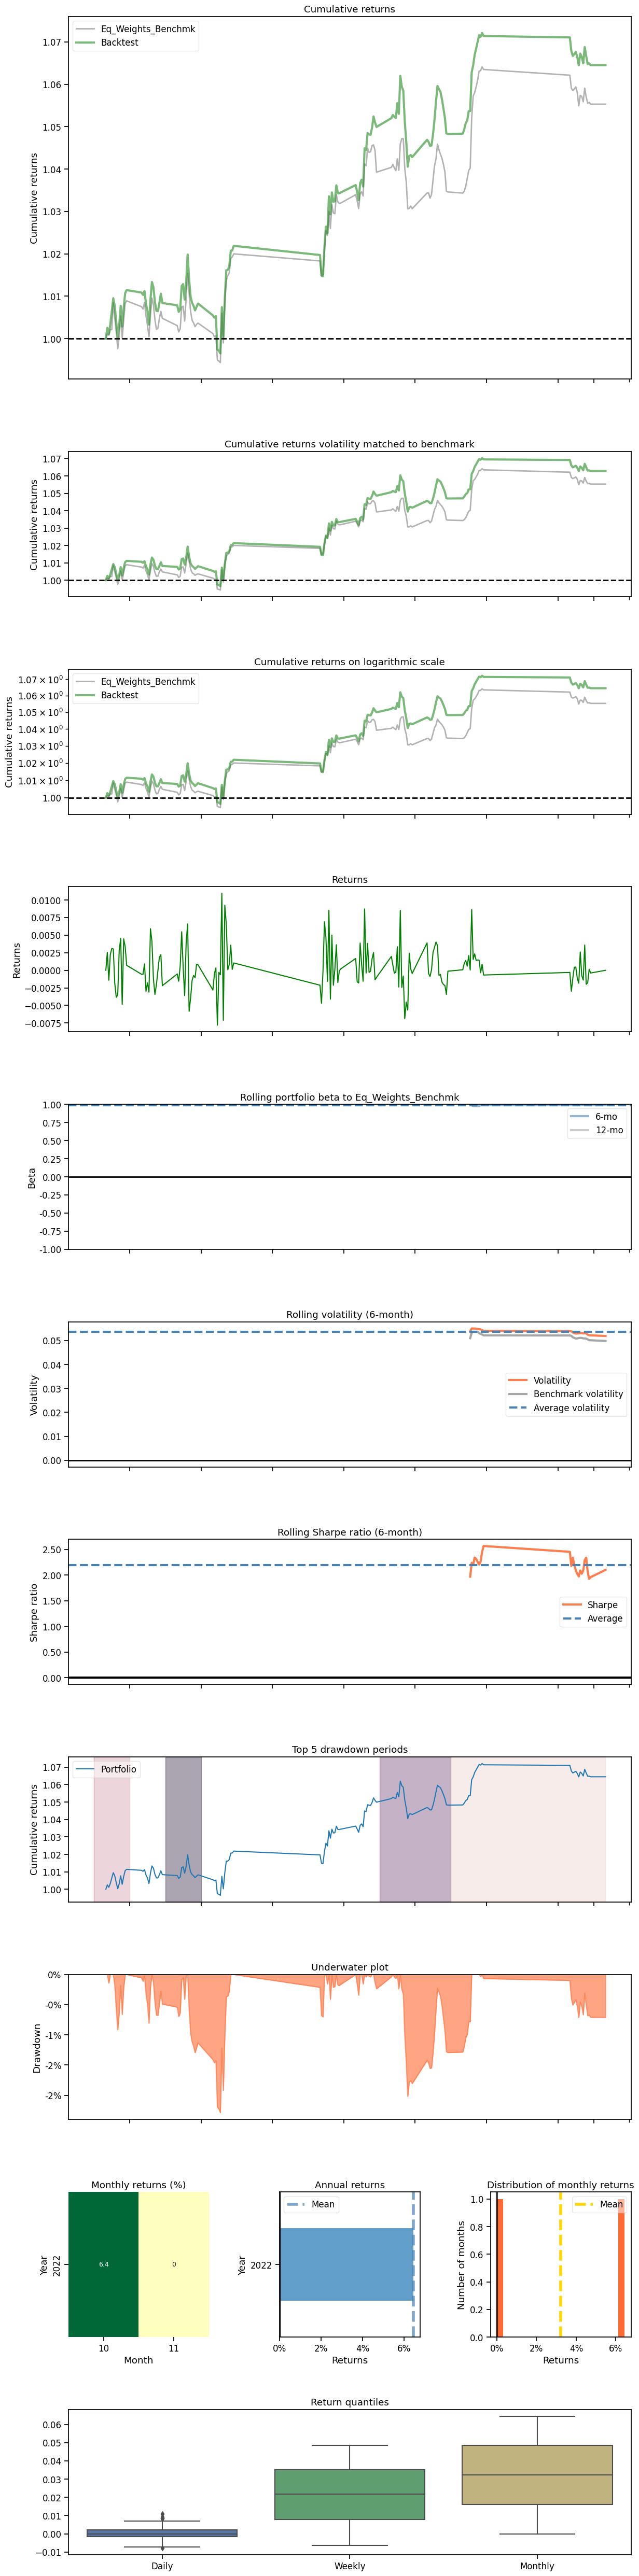

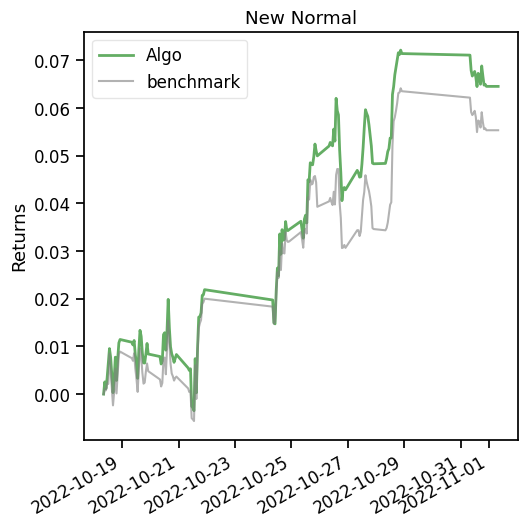

In [16]:
TD3_Agent.plot_backtest_results(df_benchmark_returns=ew_benchmark_dict_test["return_hist"],
                               benchmark_name = "Eq_Weights_Benchmk")